In [1]:
import torch
import torchvision.ops
from torch import nn
import numpy as np
import random
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt

## کد های نوشته شده از رفرنس های گرد آوری شده در متن تمرین الهام گرفته شده اند

In [2]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()
        self.padding = padding
        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     bias=True)
        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        self.modulator_conv = nn.Conv2d(in_channels,
                                     1 * kernel_size * kernel_size,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     bias=True)
        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)

    def forward(self, x):
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.
        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator
                                          )
        return x

class MNISTClassifier(nn.Module):
    def __init__(self, deformable=False):
        super(MNISTClassifier, self).__init__()
        Conv = nn.Conv2d if deformable==False else DeformableConv2d

        self.conv1 = Conv(1, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = Conv(32, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = Conv(64, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv4 = Conv(64, 128, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv5 = Conv(128, 128, kernel_size=3, stride=1, padding=1, bias=True)
        self.dropoutC = nn.Dropout2d(p=0.5)
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x) # [14, 14]
        x = torch.relu(self.conv2(x))
        x = self.pool(x) # [7, 7]
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.dropoutC(x)
        x = torch.relu(self.conv5(x))
        x = self.gap(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x


In [3]:
def plot_eval(epoch_times, accuracy, label):
  plt.plot(accuracy)
  plt.xticks(epoch_times)
  plt.title(f'{label} Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('./data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('./data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=False)


Using cuda device


100%|██████████| 9912422/9912422 [00:00<00:00, 113640171.34it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97611356.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41526908.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17688513.25it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Deformable Convolutional networks

In [4]:
epochs=14
#using deformable convultional layers
model_1 = MNISTClassifier(deformable=True).to(device)
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
begin = time()
acc_train=[]
acc_test=[]
best_test_acc = 0.
loss_function = nn.CrossEntropyLoss()
for epoch in range(1, epochs + 1):
    model_1.train()
    correct = 0
    num_data = 0
    train_loss = 0
    for (data, target) in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer_1.zero_grad()
        output = model_1(data)
        loss = loss_function(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer_1.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_data += len(data)
    train_loss /= num_data
    train_acc = 100. * correct / num_data
    acc_train.append(train_acc)
    print(f'Train set: Average loss: {train_loss:.4f}, Accuracy: {train_acc:.3f}')
    model_1.eval()
    test_loss = 0
    correct = 0
    num_data = 0
    with torch.no_grad():
        for (data, target) in tqdm(test_loader):
            org_data, target = data.to(device), target.to(device)
            for scale in np.arange(0.5, 1.6, 0.1): # [0.5, 0.6, ... ,1.2, 1.3, 1.4, 1.5]
                data = transforms.functional.affine(org_data, scale=scale, angle=0, translate=[0,0],shear=0)
                output = model_1(data)
                test_loss += loss_function(output, target).item()  # sum up batch mean loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                num_data += len(data)
    test_loss /= num_data
    test_acc = 100. * correct / num_data
    acc_test.append(test_acc)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {test_acc:.3f}')
    best_test_acc = max(best_test_acc, test_acc)

delta_t = time() - begin
minutes = int(delta_t // 60)
seconds = delta_t % 60

print("best top1 acc(%) (using deformable conv): ", f"{best_test_acc:.2f}")
print(f"execution time min:sec : {minutes}:{int(seconds)}")

100%|██████████| 938/938 [00:32<00:00, 28.82it/s]


Train set: Average loss: 0.0057, Accuracy: 87.947


100%|██████████| 157/157 [00:08<00:00, 18.69it/s]


Test set: Average loss: 0.0055, Accuracy: 89.348


100%|██████████| 938/938 [00:26<00:00, 35.99it/s]


Train set: Average loss: 0.0013, Accuracy: 97.493


100%|██████████| 157/157 [00:08<00:00, 18.42it/s]


Test set: Average loss: 0.0041, Accuracy: 92.056


100%|██████████| 938/938 [00:31<00:00, 29.68it/s]


Train set: Average loss: 0.0010, Accuracy: 98.153


100%|██████████| 157/157 [00:08<00:00, 18.43it/s]


Test set: Average loss: 0.0033, Accuracy: 93.266


100%|██████████| 938/938 [00:26<00:00, 35.82it/s]


Train set: Average loss: 0.0008, Accuracy: 98.573


100%|██████████| 157/157 [00:08<00:00, 18.83it/s]


Test set: Average loss: 0.0031, Accuracy: 93.425


100%|██████████| 938/938 [00:27<00:00, 34.47it/s]


Train set: Average loss: 0.0006, Accuracy: 98.797


100%|██████████| 157/157 [00:08<00:00, 19.17it/s]


Test set: Average loss: 0.0028, Accuracy: 94.561


100%|██████████| 938/938 [00:26<00:00, 35.44it/s]


Train set: Average loss: 0.0006, Accuracy: 98.913


100%|██████████| 157/157 [00:08<00:00, 18.38it/s]


Test set: Average loss: 0.0032, Accuracy: 93.176


100%|██████████| 938/938 [00:26<00:00, 35.80it/s]


Train set: Average loss: 0.0005, Accuracy: 99.035


100%|██████████| 157/157 [00:08<00:00, 18.34it/s]


Test set: Average loss: 0.0025, Accuracy: 95.315


100%|██████████| 938/938 [00:26<00:00, 35.61it/s]


Train set: Average loss: 0.0005, Accuracy: 99.062


100%|██████████| 157/157 [00:07<00:00, 19.89it/s]


Test set: Average loss: 0.0030, Accuracy: 93.966


100%|██████████| 938/938 [00:26<00:00, 35.49it/s]


Train set: Average loss: 0.0004, Accuracy: 99.250


100%|██████████| 157/157 [00:08<00:00, 18.48it/s]


Test set: Average loss: 0.0025, Accuracy: 95.055


100%|██████████| 938/938 [00:26<00:00, 35.46it/s]


Train set: Average loss: 0.0004, Accuracy: 99.262


100%|██████████| 157/157 [00:08<00:00, 18.59it/s]


Test set: Average loss: 0.0024, Accuracy: 95.221


100%|██████████| 938/938 [00:26<00:00, 35.47it/s]


Train set: Average loss: 0.0003, Accuracy: 99.353


100%|██████████| 157/157 [00:08<00:00, 19.25it/s]


Test set: Average loss: 0.0023, Accuracy: 95.283


100%|██████████| 938/938 [00:26<00:00, 35.52it/s]


Train set: Average loss: 0.0003, Accuracy: 99.383


100%|██████████| 157/157 [00:08<00:00, 19.28it/s]


Test set: Average loss: 0.0033, Accuracy: 93.103


100%|██████████| 938/938 [00:26<00:00, 35.58it/s]


Train set: Average loss: 0.0003, Accuracy: 99.397


100%|██████████| 157/157 [00:08<00:00, 18.41it/s]


Test set: Average loss: 0.0026, Accuracy: 94.683


100%|██████████| 938/938 [00:26<00:00, 35.68it/s]


Train set: Average loss: 0.0003, Accuracy: 99.440


100%|██████████| 157/157 [00:08<00:00, 18.39it/s]

Test set: Average loss: 0.0035, Accuracy: 93.145
best top1 acc(%) (using deformable conv):  95.32
execution time min:sec : 8:18


### execution time : 00:08:18 , Maximum testing accuracy : 95.32

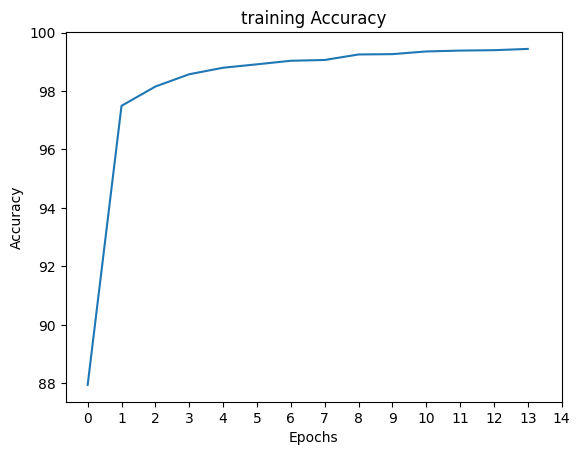

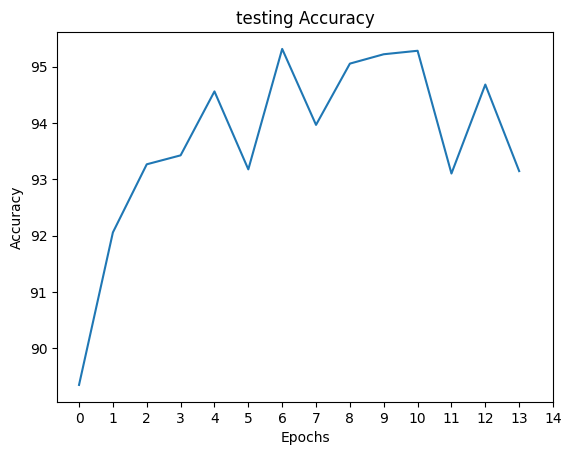

In [5]:
plot_eval(range(epochs+1),acc_train,'training')
plot_eval(range(epochs+1),acc_test,'testing')

## Common Convolutional Networks

In [6]:
#using common convultional layers
model_2 = MNISTClassifier(deformable=False).to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
begin = time()
acc_train=[]
acc_test=[]
best_test_acc = 0.
loss_function = nn.CrossEntropyLoss()
for epoch in range(1, epochs + 1):
    model_2.train()
    correct = 0
    num_data = 0
    train_loss = 0
    for (data, target) in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer_2.zero_grad()
        output = model_2(data)
        loss = loss_function(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer_2.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_data += len(data)
    train_loss /= num_data
    train_acc = 100. * correct / num_data
    acc_train.append(train_acc)
    print(f'Train set: Average loss: {train_loss:.4f}, Accuracy: {train_acc:.3f}')
    model_2.eval()
    test_loss = 0
    correct = 0
    num_data = 0
    with torch.no_grad():
        for (data, target) in tqdm(test_loader):
            org_data, target = data.to(device), target.to(device)
            for scale in np.arange(0.5, 1.6, 0.1): # [0.5, 0.6, ... ,1.2, 1.3, 1.4, 1.5]
                data = transforms.functional.affine(org_data, scale=scale, angle=0, translate=[0,0],shear=0)
                output = model_2(data)
                test_loss += loss_function(output, target).item()  # sum up batch mean loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                num_data += len(data)
    test_loss /= num_data
    test_acc = 100. * correct / num_data
    acc_test.append(test_acc)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {test_acc:.3f}')
    best_test_acc = max(best_test_acc, test_acc)

delta_t = time() - begin
minutes = int(delta_t // 60)
seconds = delta_t % 60

print("best top1 acc(%) (using common conv): ", f"{best_test_acc:.2f}")
print(f"execution time min:sec : {minutes}:{int(seconds)}")

100%|██████████| 938/938 [00:17<00:00, 52.64it/s]


Train set: Average loss: 0.0067, Accuracy: 85.642


100%|██████████| 157/157 [00:04<00:00, 31.96it/s]


Test set: Average loss: 0.0070, Accuracy: 84.842


100%|██████████| 938/938 [00:23<00:00, 39.56it/s]


Train set: Average loss: 0.0015, Accuracy: 97.140


100%|██████████| 157/157 [00:05<00:00, 28.89it/s]


Test set: Average loss: 0.0065, Accuracy: 86.957


100%|██████████| 938/938 [00:17<00:00, 52.58it/s]


Train set: Average loss: 0.0010, Accuracy: 97.962


100%|██████████| 157/157 [00:04<00:00, 31.59it/s]


Test set: Average loss: 0.0057, Accuracy: 89.320


100%|██████████| 938/938 [00:20<00:00, 46.82it/s]


Train set: Average loss: 0.0008, Accuracy: 98.463


100%|██████████| 157/157 [00:04<00:00, 33.66it/s]


Test set: Average loss: 0.0059, Accuracy: 89.259


100%|██████████| 938/938 [00:18<00:00, 51.72it/s]


Train set: Average loss: 0.0007, Accuracy: 98.713


100%|██████████| 157/157 [00:04<00:00, 31.55it/s]


Test set: Average loss: 0.0040, Accuracy: 91.682


100%|██████████| 938/938 [00:17<00:00, 52.94it/s]


Train set: Average loss: 0.0006, Accuracy: 98.883


100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


Test set: Average loss: 0.0043, Accuracy: 91.166


100%|██████████| 938/938 [00:17<00:00, 53.46it/s]


Train set: Average loss: 0.0005, Accuracy: 98.970


100%|██████████| 157/157 [00:05<00:00, 29.41it/s]


Test set: Average loss: 0.0048, Accuracy: 90.645


100%|██████████| 938/938 [00:17<00:00, 53.19it/s]


Train set: Average loss: 0.0004, Accuracy: 99.173


100%|██████████| 157/157 [00:05<00:00, 29.45it/s]


Test set: Average loss: 0.0048, Accuracy: 90.436


100%|██████████| 938/938 [00:17<00:00, 52.60it/s]


Train set: Average loss: 0.0004, Accuracy: 99.245


100%|██████████| 157/157 [00:05<00:00, 30.22it/s]


Test set: Average loss: 0.0045, Accuracy: 91.321


100%|██████████| 938/938 [00:17<00:00, 53.52it/s]


Train set: Average loss: 0.0003, Accuracy: 99.332


100%|██████████| 157/157 [00:05<00:00, 31.08it/s]


Test set: Average loss: 0.0039, Accuracy: 92.279


100%|██████████| 938/938 [00:17<00:00, 52.64it/s]


Train set: Average loss: 0.0003, Accuracy: 99.397


100%|██████████| 157/157 [00:04<00:00, 32.39it/s]


Test set: Average loss: 0.0053, Accuracy: 90.349


100%|██████████| 938/938 [00:18<00:00, 51.75it/s]


Train set: Average loss: 0.0003, Accuracy: 99.450


100%|██████████| 157/157 [00:04<00:00, 31.68it/s]


Test set: Average loss: 0.0040, Accuracy: 92.296


100%|██████████| 938/938 [00:17<00:00, 52.15it/s]


Train set: Average loss: 0.0002, Accuracy: 99.482


100%|██████████| 157/157 [00:04<00:00, 31.94it/s]


Test set: Average loss: 0.0040, Accuracy: 91.983


100%|██████████| 938/938 [00:18<00:00, 52.10it/s]


Train set: Average loss: 0.0002, Accuracy: 99.552


100%|██████████| 157/157 [00:04<00:00, 32.49it/s]

Test set: Average loss: 0.0046, Accuracy: 91.225
best top1 acc(%) (using common conv):  92.30
execution time min:sec : 5:30


### execution time : 00:05:30 , Maximum testing accuracy : 92.30

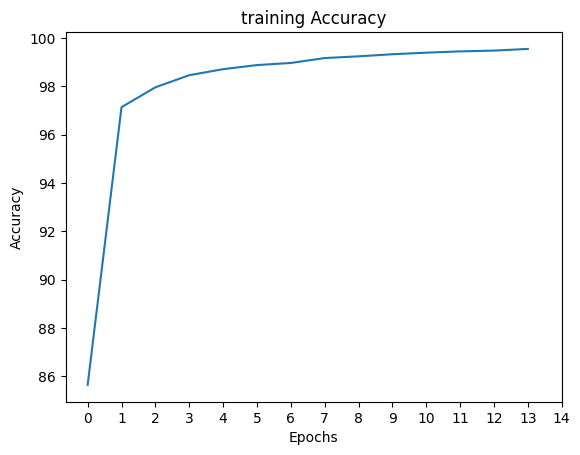

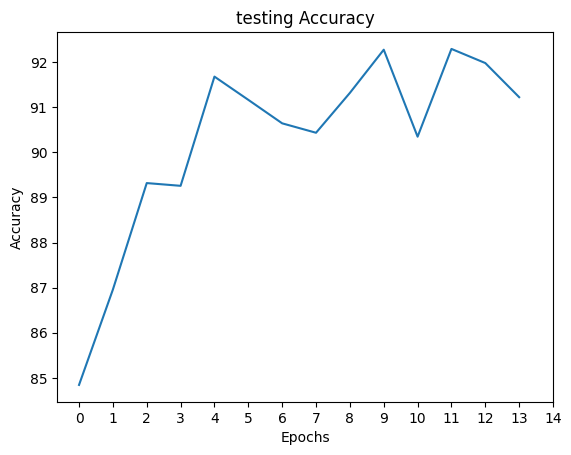

In [7]:
plot_eval(range(epochs+1),acc_train,'training')
plot_eval(range(epochs+1),acc_test,'testing')